# **Regularisation in PyTorch - Part 1**
### **First we train a CNN on the Fashion-MNIST Dataset usng NO Regularisation Methods**

---


In this lesson, we first learn to create a **simple Convolutional Neural Network model** in PyTorch and train it to **classify images in the Fashion-MNIST Dataset**, without the use of any regularisation methods.
1. Import PyTorch libraries, define our Transformers, Load our dataset and Visualize our images.
2. Build a Simple CNN without Regularisation
3. Train Our CNN
3. Take a look at Data Augmentation

# **Import PyTorch libraries, Define Transfomers and Load & Visualise Dataset**

In [1]:
# Import PyTorch
import torch
import PIL

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))
device = 'cuda' #'cpu' if no GPU available

GPU available: True


### **Our Data Transform**

In [2]:
# Transform to a PyTorch tensors and the normalize our valeus between -1 and +1
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])

In [3]:
# Load our Training Data and specify what transform to use when loading
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:00<00:00, 121683739.33it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 98406106.96it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65441548.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19882391.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

# Create a list with our class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [7]:
# We have 60,000 Image samples for our training data & 10,000 for our test data
# each 28 x 28 pixels, as they are grayscale, there is no 3rd dimension to our image
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# **2. Building and Training Our Simple CNN with No Regularisation**

#### **Defining Our Model**

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### **Defining our Loss and Optimisation Functions**

In [9]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# **3. Training Our Model**

In [10]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 15

# Create some empty arrays to store logs
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accurachy
        running_loss += loss.item()
        if i % 100 == 99:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)

                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 3.769, Test Accuracy = 61.560%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.690, Test Accuracy = 73.000%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.443, Test Accuracy = 72.940%
Epoch: 1, Mini-Batches Completed: 400, Loss: 1.337, Test Accuracy = 75.920%
Epoch: 1, Mini-Batches Completed: 500, Loss: 1.285, Test Accuracy = 71.800%
Epoch: 1, Mini-Batches Completed: 600, Loss: 1.238, Test Accuracy = 76.530%
Epoch: 1, Mini-Batches Completed: 700, Loss: 1.204, Test Accuracy = 75.650%
Epoch: 1, Mini-Batches Completed: 800, Loss: 1.162, Test Accuracy = 76.280%
Epoch: 1, Mini-Batches Completed: 900, Loss: 1.142, Test Accuracy = 76.280%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 1.107, Test Accuracy = 77.320%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 1.105, Test Accuracy = 79.760%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 1.137, Test Accuracy = 78.810%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 1.047, Test Accura

#### **Our Model's Accuracy**

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 91.29%


#### **Our Training Plots**

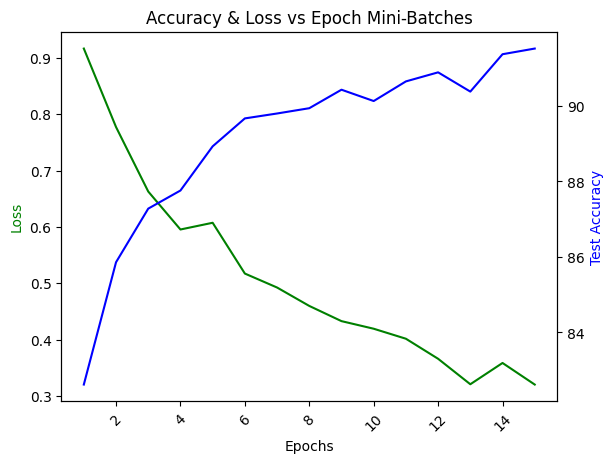

In [13]:
import matplotlib.pyplot as plt
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

# **4. Data Augumentation**

To introduce Data Augmentation to our training data we simply create new Transform functions.

**Recall our previous transformation function**

```transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])```

### **We are going to firstly demonstrate how Data Augmentation Affects Our Images**

In [15]:
# We import PIL, an Image Processing library to implement random rotations
import PIL

data_aug_transform = transforms.Compose([
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5),
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels = 1)
])

#### **Perform the Data Augmentatin on a Single Image using the function below to Visualize the effects**

In [16]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showAugmentations(image, augmentations = 6):
    fig = figure()
    for i in range(augmentations):
        a = fig.add_subplot(1,augmentations,i+1)
        img = data_aug_transform(image)
        imshow(img ,cmap='Greys_r')
        axis('off')

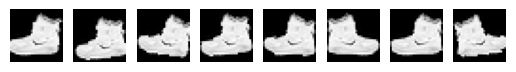

In [17]:
# Load the first Image from our training data as a numpy array
image = trainset.data[0].numpy()

# Convert it to PIL image's format
img_pil = PIL.Image.fromarray(image)

showAugmentations(img_pil, 8)